In [79]:
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import util
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
import itertools
import pyramid
import datetime as dt
%matplotlib inline


print('numpy version: %r' % np.__version__)
print('pyramid version: %r' % pyramid.__version__)

numpy version: '1.14.0'
pyramid version: '0.6.5'


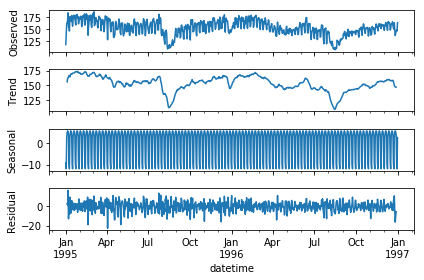

In [80]:
data, meta = util.read_arf('powersupply.arff');

data = list(map(lambda x: (x[0], x[1], int(x[2])), data))

x = list(filter(lambda x: int(x[2]) == 0, data))

dates = pd.date_range('1995-01-01', periods=len(x), freq='D')

x = pd.DataFrame(x)
x.rename(columns={0: 'main_grid',1: 'other_grid', 2: 'hour'}, inplace=True)

lst = list(filter(lambda x: x.hour == 0,dates))

lst = lst[:len(lst)-((len(lst) - len(x)))]

x['datetime'] = lst
x.set_index('datetime', inplace = True)

x = x[x.index.year != 1998]

y = x[x.index.year != 1997]
t = x[x.index.year == 1997]

y = pd.Series(y['main_grid'])

result = seasonal_decompose(y, model='additive')

result.plot()

plt.show()

# y.plot(figsize=(15, 6))
# plt.show()

In [81]:
stepwise_fit = auto_arima(y, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5318.113, BIC=5341.085, Fit time=4.752 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5789.645, BIC=5808.023, Fit time=1.197 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5434.147, BIC=5452.524, Fit time=2.568 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5336.933, BIC=5364.500, Fit time=4.822 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5850.049, BIC=5868.427, Fit time=1.056 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5322.684, BIC=5350.251, Fit time=12.725 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5317.900, BIC=5350.060, Fit time=21.480 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5427.407, BIC=5454.974, Fit time=8.198 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_or

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  731
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -2603.758
Date:                            Sun, 03 Jun 2018   AIC                           5223.516
Time:                                    16:12:54   BIC                           5260.271
Sample:                                         0   HQIC                          5237.696
                                            - 731                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.006      0.139      0.890      -0.011       0.012
ar.L1          0.3362      0.055      6.155      0.000       0.229       0.443
ar.L2         -0.1823      0.045     -4.020      0.000      -0.271      -0.093
ma.L1         -0.7647      0.042    -18.217      0.000      -0.847      -0.682
ar.S.L12      -0.2349      0.042     -5.528      0.000      -0.318      -0.152
ar.S.L24      -0.2668      0.043     -6.157      0.000      -0.352      -0.182
ma.S.L12      -0.9798      0.035    -27.824      0.000      -1.049      -0.911
sigma2        77.4294      4.173     18.554      0.000      69.250      85.609
===================================================================================
Ljung-Box (Q):                      833.77   Jarque-Bera (JB):                20.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
next_year_prediction= stepwise_fit.predict(n_periods=365)

forecasted_year_series = pd.Series(next_year_prediction, index=t.index)

true_values = t['main_grid'].values

predicted_values = next_year_prediction;

mse = ((predicted_values - true_values) ** 2).mean()
print('The Mean Squared Error {}'.format(round(mse, 2)))

The Mean Squared Error 190.33


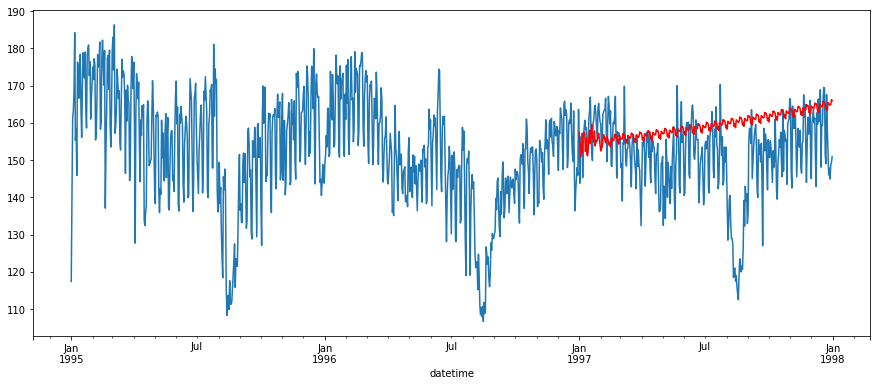

In [85]:


ax = pd.Series(x['main_grid']).plot(figsize=(15, 6))

forecasted_year_series.plot(color='red', ax=ax)
plt.show()
